In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [ ]:
# Load the dataset
df = pd.read_csv("C:/Users/Sina/Documents/HSG/Econ Bachelor/DSF/log_filtered.csv")
train = pd.read_csv("C:/Users/Sina/Documents/HSG/Econ Bachelor/DSF/log_train.csv")
test = pd.read_csv("C:/Users/Sina/Documents/HSG/Econ Bachelor/DSF/log_test.csv")

Procedure chosen: use whole data to inspect for seasonal patterns and trends (first seasonal because ADF test won't detect trend if seasonality persists), and if seasonality is consistent across the entire dataset, can detrend and deseason test and training data seperately in order to avoid data leackage.

Why not just add cyclical features for lin reg? Linear regression tries to fit a line that best explains the relationship between the features and the target variable.
If a feature has a strong trend but the target variable does not, the model might pick up the trend in the feature as a spurious relationship, leading to misleading or poor predictions. If the feature's trend is unrelated to the target variable, it introduces noise into the regression model. This reduces the model's ability to learn meaningful relationships between features and the target. We'll see that's the case here!

In [ ]:
#drop col Water levels and move log water levels to the first place / replace water levels with log water levels:

df['WATER_LEVEL'] = df['LOG_WATER_LEVEL']

df.drop('LOG_WATER_LEVEL', axis=1)
train['WATER_LEVEL'] = train['LOG_WATER_LEVEL']

train.drop('LOG_WATER_LEVEL', axis=1)
test['WATER_LEVEL'] = test['LOG_WATER_LEVEL']

test.drop('LOG_WATER_LEVEL', axis=1)
# Check the result
print(df.head())

         DATE  WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0  1973-01-01     5.638355      76.0      -22.0            0.0   10291.0   
1  1973-01-02     5.634790      83.0      -25.0            0.0   10263.0   
2  1973-01-03     5.631212      83.0       -9.0            0.0   10288.0   
3  1973-01-04     5.627621      80.0        0.0            0.0   10297.0   
4  1973-01-05     5.620401      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  MOON_ILLUMINATION  \
0         0.0      75.0         7.0              73.0  ...           18.48788   
1         0.0      23.0        10.0              46.0  ...           11.76654   
2         0.0      21.0         6.0              45.0  ...            6.38749   
3         0.0      11.0        11.0              37.0  ...            2.54398   
4         0.0       8.0        21.0              34.0  ...            0.40753   

   CLIMATE_CHANGE  WATER_LEVEL_LAG_1  WATER_LEVEL_LAG_2 

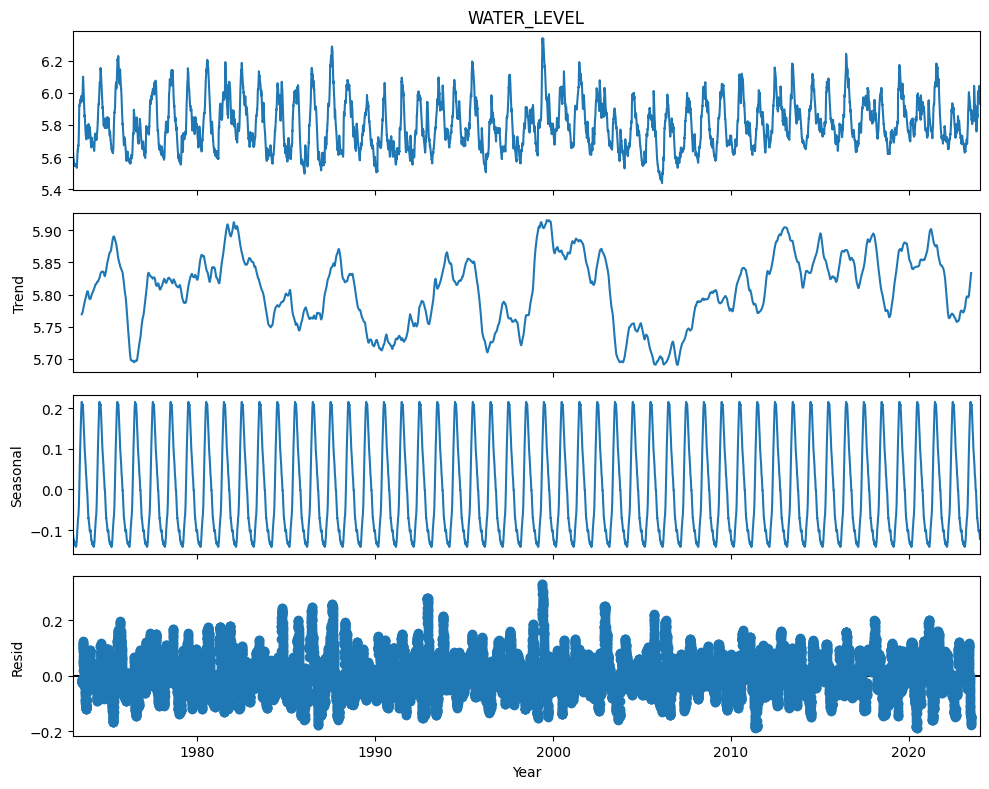

In [ ]:
#decompose to get overview

df['DATE'] = pd.to_datetime(df['DATE'])

df.set_index('DATE', inplace=True)

# Decompose the time series
result = seasonal_decompose(df['WATER_LEVEL'], model='additive', period=365)

# Plot
fig = result.plot()
fig.set_size_inches(10, 8)

for ax in fig.axes[:-1]:
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel("")

fig.axes[-1].xaxis.set_major_locator(mdates.YearLocator(10))
fig.axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.axes[-1].set_xlabel("Year")

plt.tight_layout()
plt.show()
#see clear seasonality

#The trend here suggests that there are no longer-term trend but short-term fluctuations, but these are not consistent or linear.
#this means, it appears to rise and fall over different time periods.


df.reset_index(inplace=True)

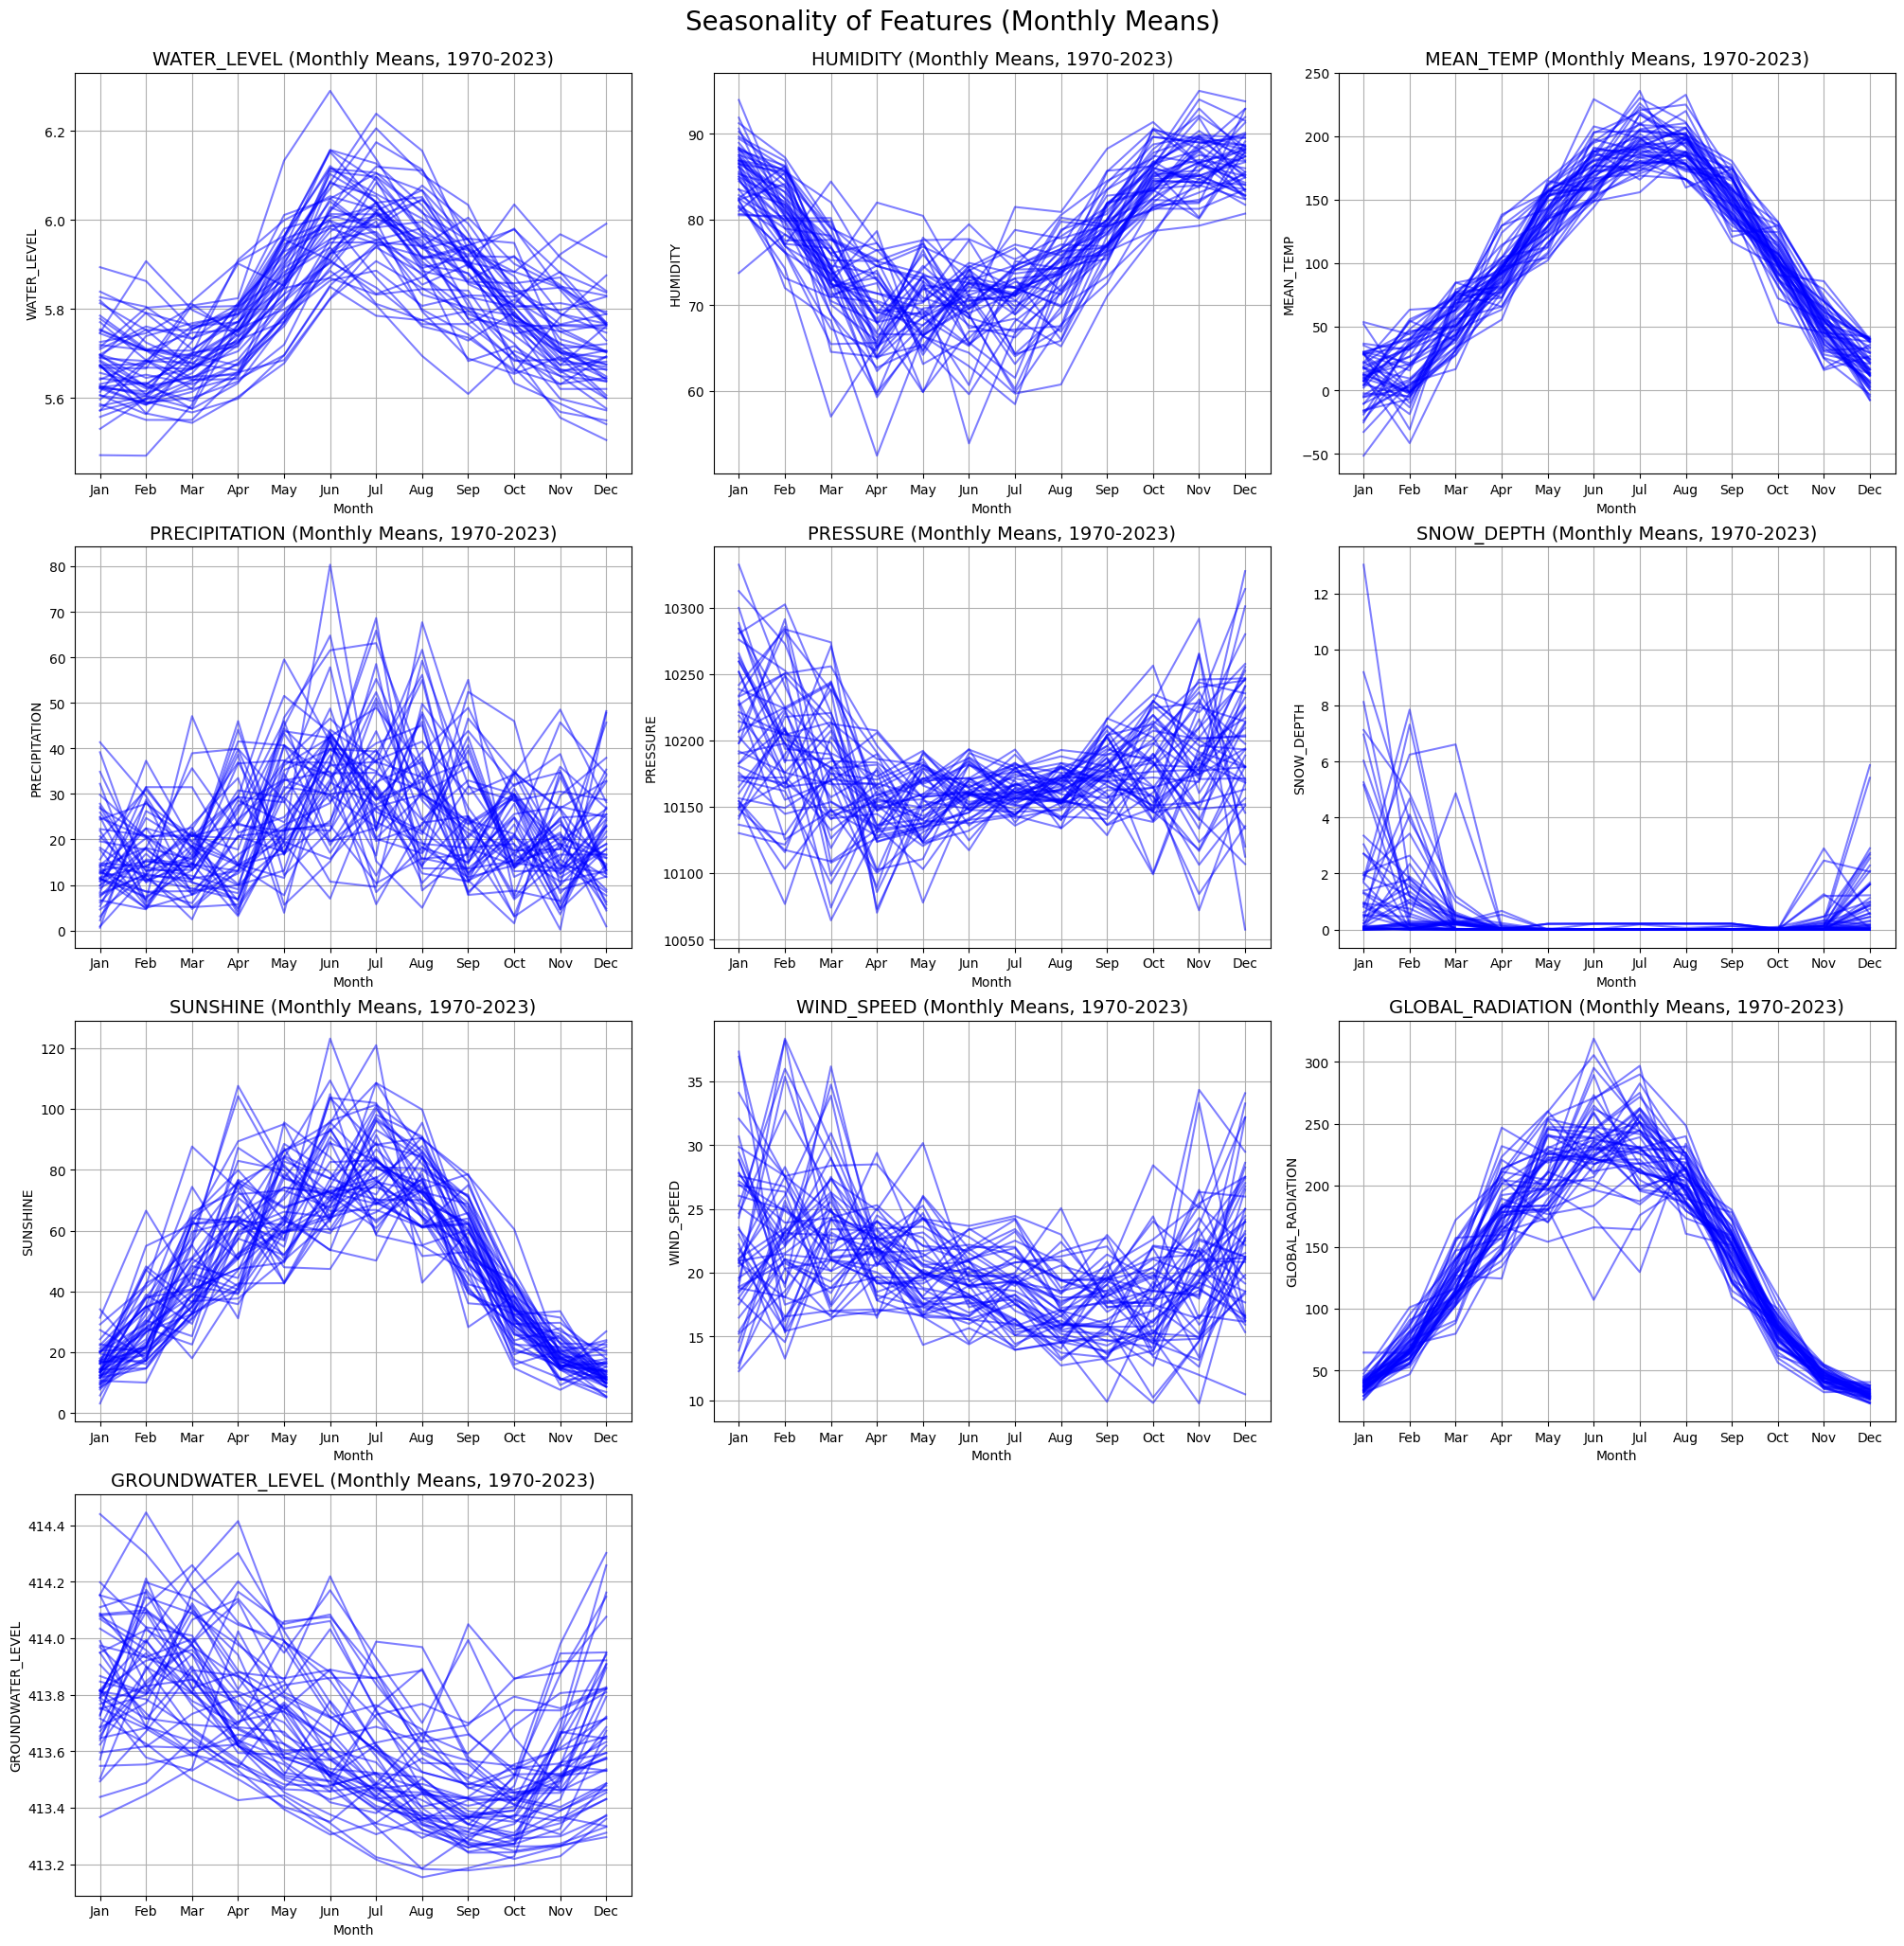

In [ ]:
#for seasonality: saw in other feature engineering clear seasonality of water levels-> need to deseason and deseason lagged features
#for other features first plot:
df['Month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year

#take monthly mean because detected high daily variability -> taking monthly means can help reveal broader seasonal trends
monthly_means = df.groupby(['year', 'Month']).mean().reset_index()

# List of features to plot
features = ['WATER_LEVEL', 'HUMIDITY', 'MEAN_TEMP', 'PRECIPITATION', 'PRESSURE',
            'SNOW_DEPTH', 'SUNSHINE', 'WIND_SPEED', 'GLOBAL_RADIATION',
            'GROUNDWATER_LEVEL']

# Monthly start days for x-axis
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create subplots
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    for year in monthly_means['year'].unique():
        yearly_data = monthly_means[monthly_means['year'] == year]
        ax.plot(yearly_data['Month'], yearly_data[feature], alpha=0.5, color="blue")

    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels)
    ax.set_title(f"{feature} (Monthly Means, 1970-2023)", fontsize=14)
    ax.set_xlabel("Month")
    ax.set_ylabel(feature)
    ax.grid(True)

# Hide unused subplots
for i in range(len(features), len(axes)):
    axes[i].axis('off')

plt.suptitle("Seasonality of Features (Monthly Means)", fontsize=20, y=1.02)
plt.show()

#we can see that
#MEAN_TEMP, SUNSHINE, global radiation, precpitation and humidity how potential correlation or shared seasonality with water levels


In [ ]:

#-> check explicitly if the seasonality of all features are linearly correlated to the seasonality of the water levels:

#use comparison of 3cycles in case seasonality changes
extended_monthly_means = pd.concat([monthly_means] * 3, ignore_index=True)

# Extract seasonal components for each feature and average across cycles
seasonal_components = {}
for feature in features:
    decomposition = seasonal_decompose(extended_monthly_means[feature], model='additive', period=12)

    # full seasonal component for all cycles
    seasonal_full = decomposition.seasonal

    # average over multiple cycles
    seasonal_mean = seasonal_full.groupby(seasonal_full.index % 12).mean()
    seasonal_components[feature] = seasonal_mean.values  # Convert to array

seasonal_df = pd.DataFrame(seasonal_components)

seasonal_df.index = range(1, 13)
seasonal_df.index.name = 'Month'

seasonal_df = pd.DataFrame(seasonal_components)
#print(seasonal_df)

# Compute correlations between seasonal components
correlations = {}
target = 'WATER_LEVEL'
for feature in ['HUMIDITY', 'MEAN_TEMP', 'PRECIPITATION', 'PRESSURE',
            'SNOW_DEPTH', 'SUNSHINE', 'WIND_SPEED', 'GLOBAL_RADIATION',
            'GROUNDWATER_LEVEL']:
    correlations[feature] = seasonal_df[target].corr(seasonal_df[feature])

# Display correlations
for feature, corr in correlations.items():
    print(f"Seasonal Correlation between WATER_LEVEL and {feature}: {corr:.2f}")
#-> have moderate seasonal linear correlations between all features (absolute value of correlation coefficient is bigger than 0.5 for all of them)
# and the target value (negative seasonal correlation for some of them)
#choose threshold of 0.5 because correlation of 0.5 or above typically indicates a moderately strong relationship
# ->  Irecommended to deseasonalize those features. This will help the model
# focus on non-seasonal relationships or anomalies that might be more meaningful for prediction with linear regression models.


Seasonal Correlation between WATER_LEVEL and HUMIDITY: -0.60
Seasonal Correlation between WATER_LEVEL and MEAN_TEMP: 0.96
Seasonal Correlation between WATER_LEVEL and PRECIPITATION: 0.98
Seasonal Correlation between WATER_LEVEL and PRESSURE: -0.64
Seasonal Correlation between WATER_LEVEL and SNOW_DEPTH: -0.67
Seasonal Correlation between WATER_LEVEL and SUNSHINE: 0.84
Seasonal Correlation between WATER_LEVEL and WIND_SPEED: -0.76
Seasonal Correlation between WATER_LEVEL and GLOBAL_RADIATION: 0.84
Seasonal Correlation between WATER_LEVEL and GROUNDWATER_LEVEL: -0.59


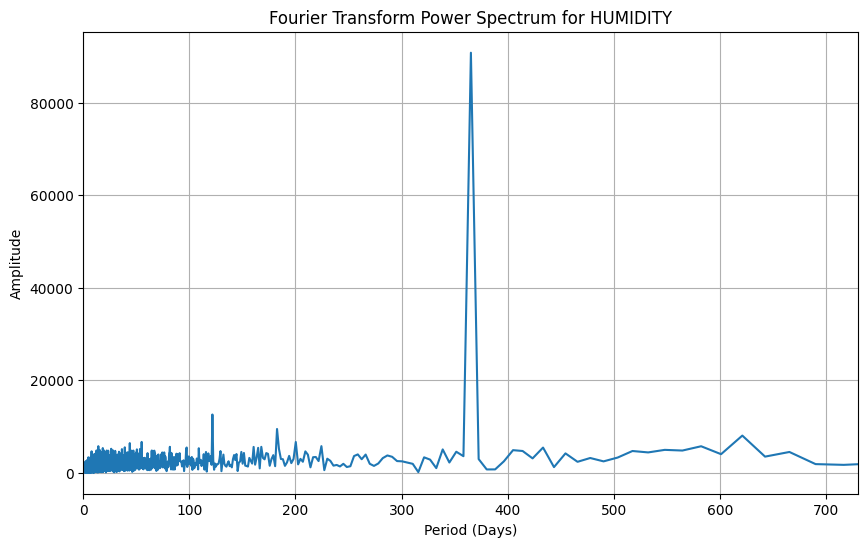

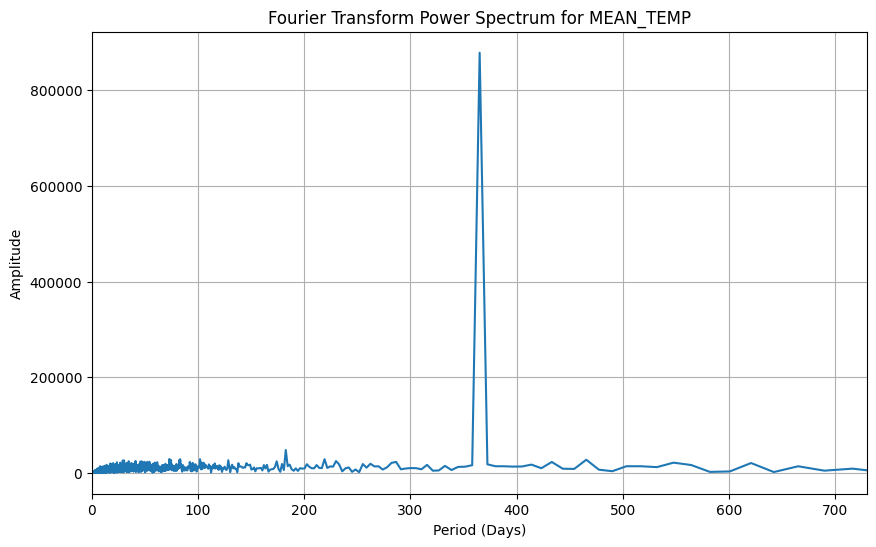

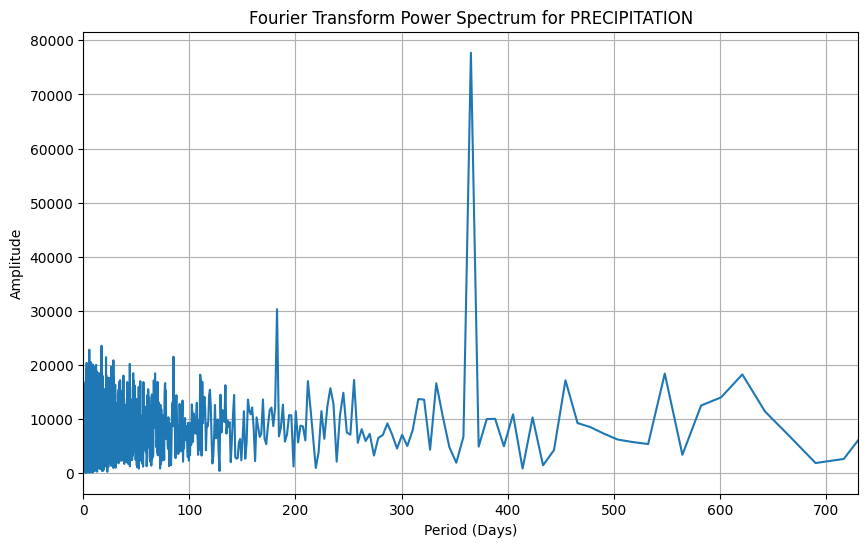

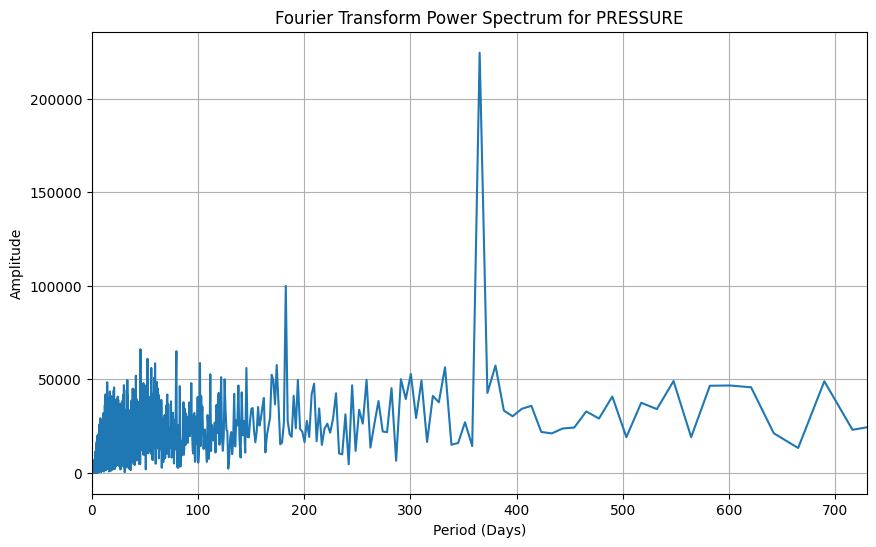

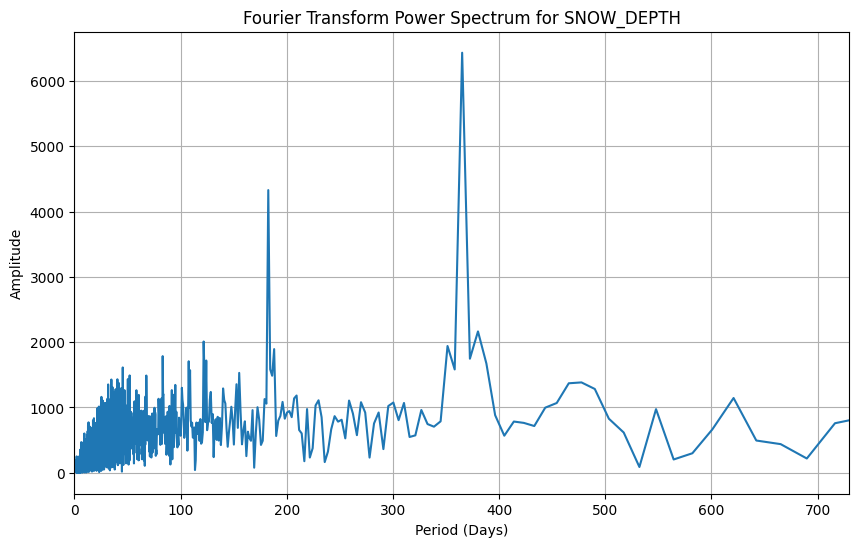

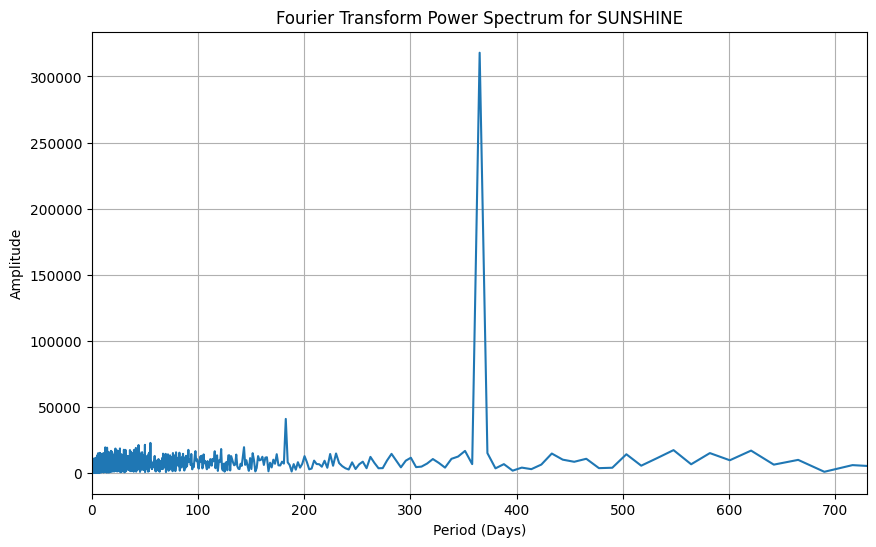

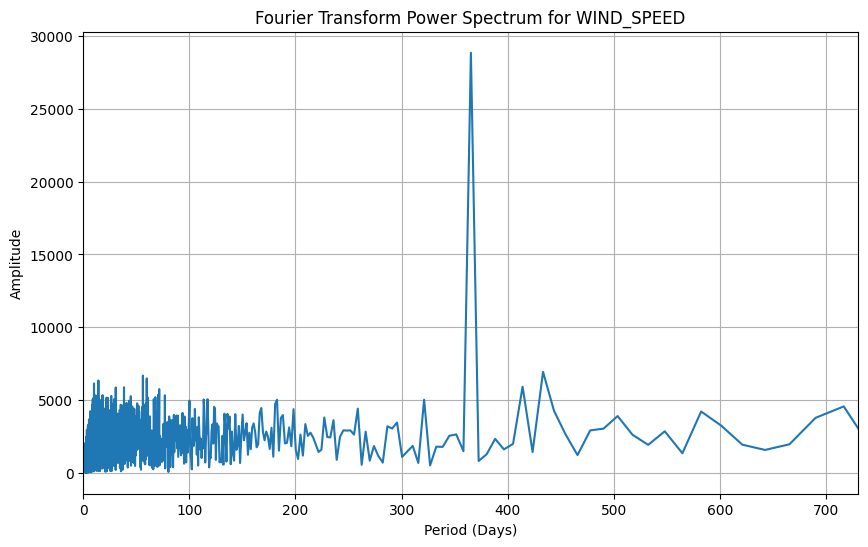

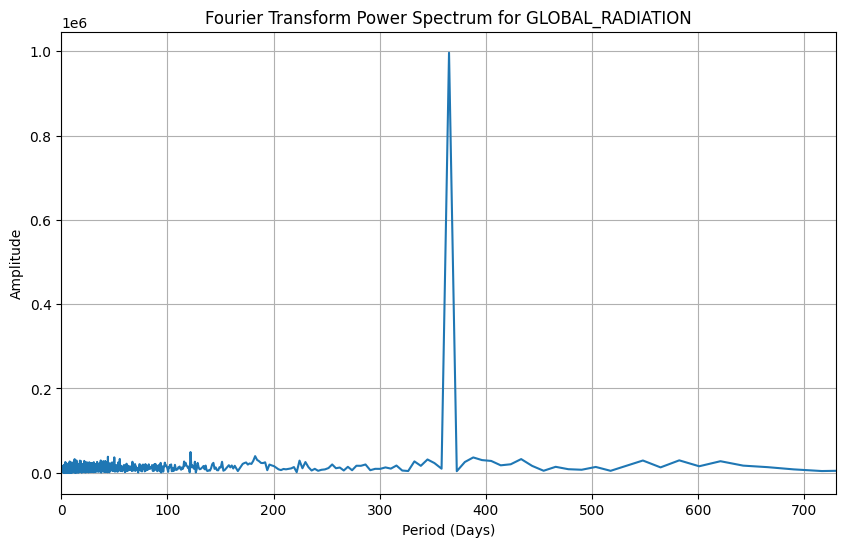

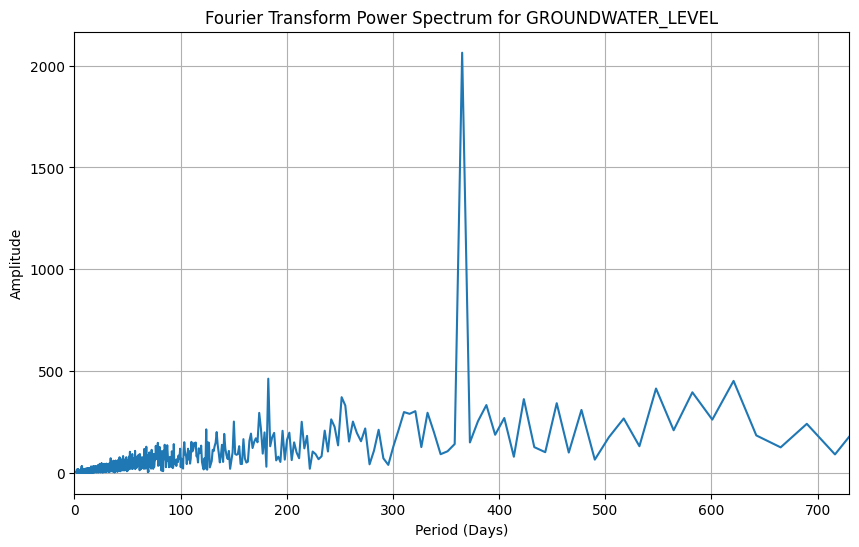

In [ ]:
import numpy as np
#look for periodicity of features with FUrrier Transformation (https://de.wikipedia.org/wiki/Fourier-Transformation):
features = ['HUMIDITY', 'MEAN_TEMP', 'PRECIPITATION', 'PRESSURE',
            'SNOW_DEPTH', 'SUNSHINE', 'WIND_SPEED', 'GLOBAL_RADIATION',
            'GROUNDWATER_LEVEL']


for feature in features:
    fft_result = np.fft.fft(df[feature])
    frequencies = np.fft.fftfreq(len(fft_result))
    plt.figure(figsize=(10, 6))
    plt.plot(1 / frequencies[1:len(frequencies)//2], np.abs(fft_result)[1:len(frequencies)//2])
    plt.xlim(0, 2 * 365)
    plt.title(f"Fourier Transform Power Spectrum for {feature}")
    plt.xlabel("Period (Days)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
#Observations/ Comparison to Furrier Transformation of Water_Levels (focus on yearly and 180-daily periods as they
# were observed in Furrier Transformation of water levels):
#want only to remove those seasonalities that are shared with target variable because: Deseasonalizing features that share the same seasonal patterns
#as the target prevents the model from misinterpreting the shared seasonality as a meaningful relationship.
#Removing irrelevant seasonality (that doesn't align with the target) might remove useful predictive information.

#Have only yearly peak:
#Humidity
#Mean temp
#global ratiation
#wind speed

#Have yearly and half year peaks:
#Precipitation
#Pressure
#Snow_depth
#Sunshine
#Groundwater_level

Correlation between lunar cycle (checked for 12 cycles) of WATER_LEVEL and MOON_ILLUMINATION: 0.00
Correlation between lunar cycle of WATER_LEVEL and MOON_ILLUMINATION: 0.00


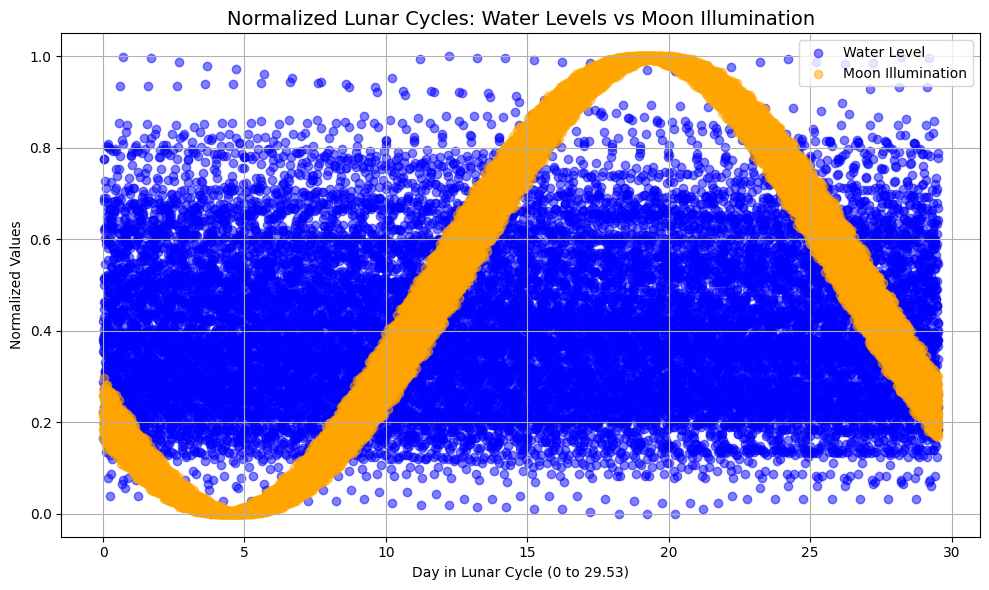

In [ ]:
#need to check the same for moon cycle but monthly:
from sklearn.preprocessing import MinMaxScaler

# Calculate the moon cycle day (1 to 29.53 days repeating)
df['Lunar_Cycle_Day'] = (df['DATE'] - df['DATE'].min()).dt.days % 29.53

# Select data for the first 3 lunar cycles
lunar_cycle_length = 29.53
first_12_cycles = df[df['Lunar_Cycle_Day'] < 12 * lunar_cycle_length]

# Normalize WATER_LEVEL and MOON_ILLUMINATION for nicer plotting
scaler = MinMaxScaler()
df[['WATER_LEVEL2', 'MOON_ILLUMINATION2']] = scaler.fit_transform(df[['WATER_LEVEL', 'MOON_ILLUMINATION']])

# correlation
correlation = first_12_cycles['WATER_LEVEL2'].corr(first_12_cycles['MOON_ILLUMINATION2'])
#no correlation, check also for whole dataset:
correlation2 = df['WATER_LEVEL2'].corr(df['MOON_ILLUMINATION2'])
#also no correlation -> not gonna deseason

print(f"Correlation between lunar cycle (checked for 12 cycles) of WATER_LEVEL and MOON_ILLUMINATION: {correlation:.2f}")
print(f"Correlation between lunar cycle of WATER_LEVEL and MOON_ILLUMINATION: {correlation2:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Lunar_Cycle_Day'], df['WATER_LEVEL2'], label="Water Level", alpha=0.5, color='blue')
plt.scatter(df['Lunar_Cycle_Day'], df['MOON_ILLUMINATION2'], label="Moon Illumination", alpha=0.5, color='orange')
plt.title("Normalized Lunar Cycles: Water Levels vs Moon Illumination", fontsize=14)
plt.xlabel("Day in Lunar Cycle (0 to 29.53)")
plt.ylabel("Normalized Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#can't find a correlation-> not gonna deseason

In [ ]:
df.drop(['year','Month', 'Lunar_Cycle_Day', 'WATER_LEVEL2', 'MOON_ILLUMINATION2'], axis=1, inplace=True)
print(df.head())

        DATE  WATER_LEVEL  HUMIDITY  MEAN_TEMP  PRECIPITATION  PRESSURE  \
0 1973-01-01     5.638355      76.0      -22.0            0.0   10291.0   
1 1973-01-02     5.634790      83.0      -25.0            0.0   10263.0   
2 1973-01-03     5.631212      83.0       -9.0            0.0   10288.0   
3 1973-01-04     5.627621      80.0        0.0            0.0   10297.0   
4 1973-01-05     5.620401      83.0       -1.0            0.0   10331.0   

   SNOW_DEPTH  SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  MOON_ILLUMINATION  \
0         0.0      75.0         7.0              73.0  ...           18.48788   
1         0.0      23.0        10.0              46.0  ...           11.76654   
2         0.0      21.0         6.0              45.0  ...            6.38749   
3         0.0      11.0        11.0              37.0  ...            2.54398   
4         0.0       8.0        21.0              34.0  ...            0.40753   

   CLIMATE_CHANGE  WATER_LEVEL_LAG_1  WATER_LEVEL_LAG_2  WATER

In [ ]:
#deseason:
# List of features with additional 180-day seasonality
features_with_180_day_seasonality = [
    'WATER_LEVEL', 'WATER_LEVEL_LAG_1', 'WATER_LEVEL_LAG_2', 'WATER_LEVEL_LAG_3',
    'WATER_LEVEL_LAG_4', 'WATER_LEVEL_LAG_5', 'WATER_LEVEL_LAG_6', 'WATER_LEVEL_LAG_7',
    'PRECIPITATION', 'PRESSURE', 'SNOW_DEPTH', 'SUNSHINE', 'GROUNDWATER_LEVEL'
]

# List of all features to deseasonalize
columns_to_deseasonalize = [
    'HUMIDITY', 'MEAN_TEMP', 'PRECIPITATION', 'PRESSURE', 'SNOW_DEPTH', 'SUNSHINE',
    'WIND_SPEED', 'GLOBAL_RADIATION', 'GROUNDWATER_LEVEL', 'WATER_LEVEL',
    'WATER_LEVEL_LAG_1', 'WATER_LEVEL_LAG_2', 'WATER_LEVEL_LAG_3', 'WATER_LEVEL_LAG_4',
    'WATER_LEVEL_LAG_5', 'WATER_LEVEL_LAG_6', 'WATER_LEVEL_LAG_7'
]
# Deseasonalize for df (to plot further), train, and test (separately to avoid data leackage)
datasets = {'df': df, 'train': train, 'test': test}

for dataset_name, dataset in datasets.items():
    for column in columns_to_deseasonalize:
        combined_seasonal = 0
        decomposition_365 = seasonal_decompose(dataset[column], model='additive', period=365, extrapolate_trend='freq')
        combined_seasonal += decomposition_365.seasonal

        # Add 180-day seasonality
        if column in features_with_180_day_seasonality:
            decomposition_180 = seasonal_decompose(dataset[column], model='additive', period=180, extrapolate_trend='freq')
            combined_seasonal += decomposition_180.seasonal

        dataset[column] = dataset[column] - combined_seasonal


In [ ]:
#check for NAN's:
nans_per_column = df.isna().sum()
print("NaNs per column:")
print(nans_per_column)

NaNs per column:
DATE                 0
WATER_LEVEL          0
HUMIDITY             0
MEAN_TEMP            0
PRECIPITATION        0
PRESSURE             0
SNOW_DEPTH           0
SUNSHINE             0
WIND_SPEED           0
GLOBAL_RADIATION     0
GROUNDWATER_LEVEL    0
MOON_ILLUMINATION    0
CLIMATE_CHANGE       0
WATER_LEVEL_LAG_1    0
WATER_LEVEL_LAG_2    0
WATER_LEVEL_LAG_3    0
WATER_LEVEL_LAG_4    0
WATER_LEVEL_LAG_5    0
WATER_LEVEL_LAG_6    0
WATER_LEVEL_LAG_7    0
LOG_WATER_LEVEL      0
dtype: int64


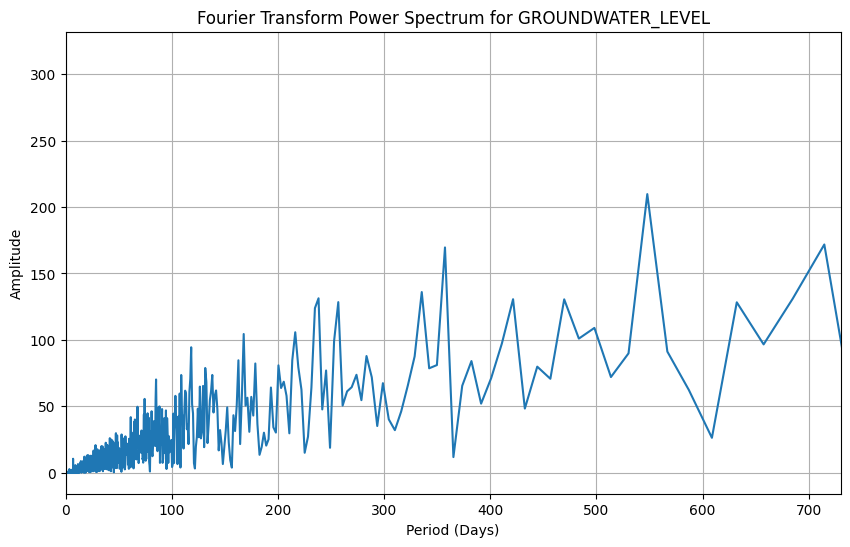

In [ ]:
#look on furrier transformation of train data
fft_result = np.fft.fft(train['WATER_LEVEL'].dropna())
frequencies = np.fft.fftfreq(len(fft_result))
plt.figure(figsize=(10, 6))
plt.plot(1 / frequencies[1:len(frequencies)//2], np.abs(fft_result)[1:len(frequencies)//2])
plt.xlim(0, 2 * 365)
plt.title(f"Fourier Transform Power Spectrum for {feature}")
plt.xlabel("Period (Days)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

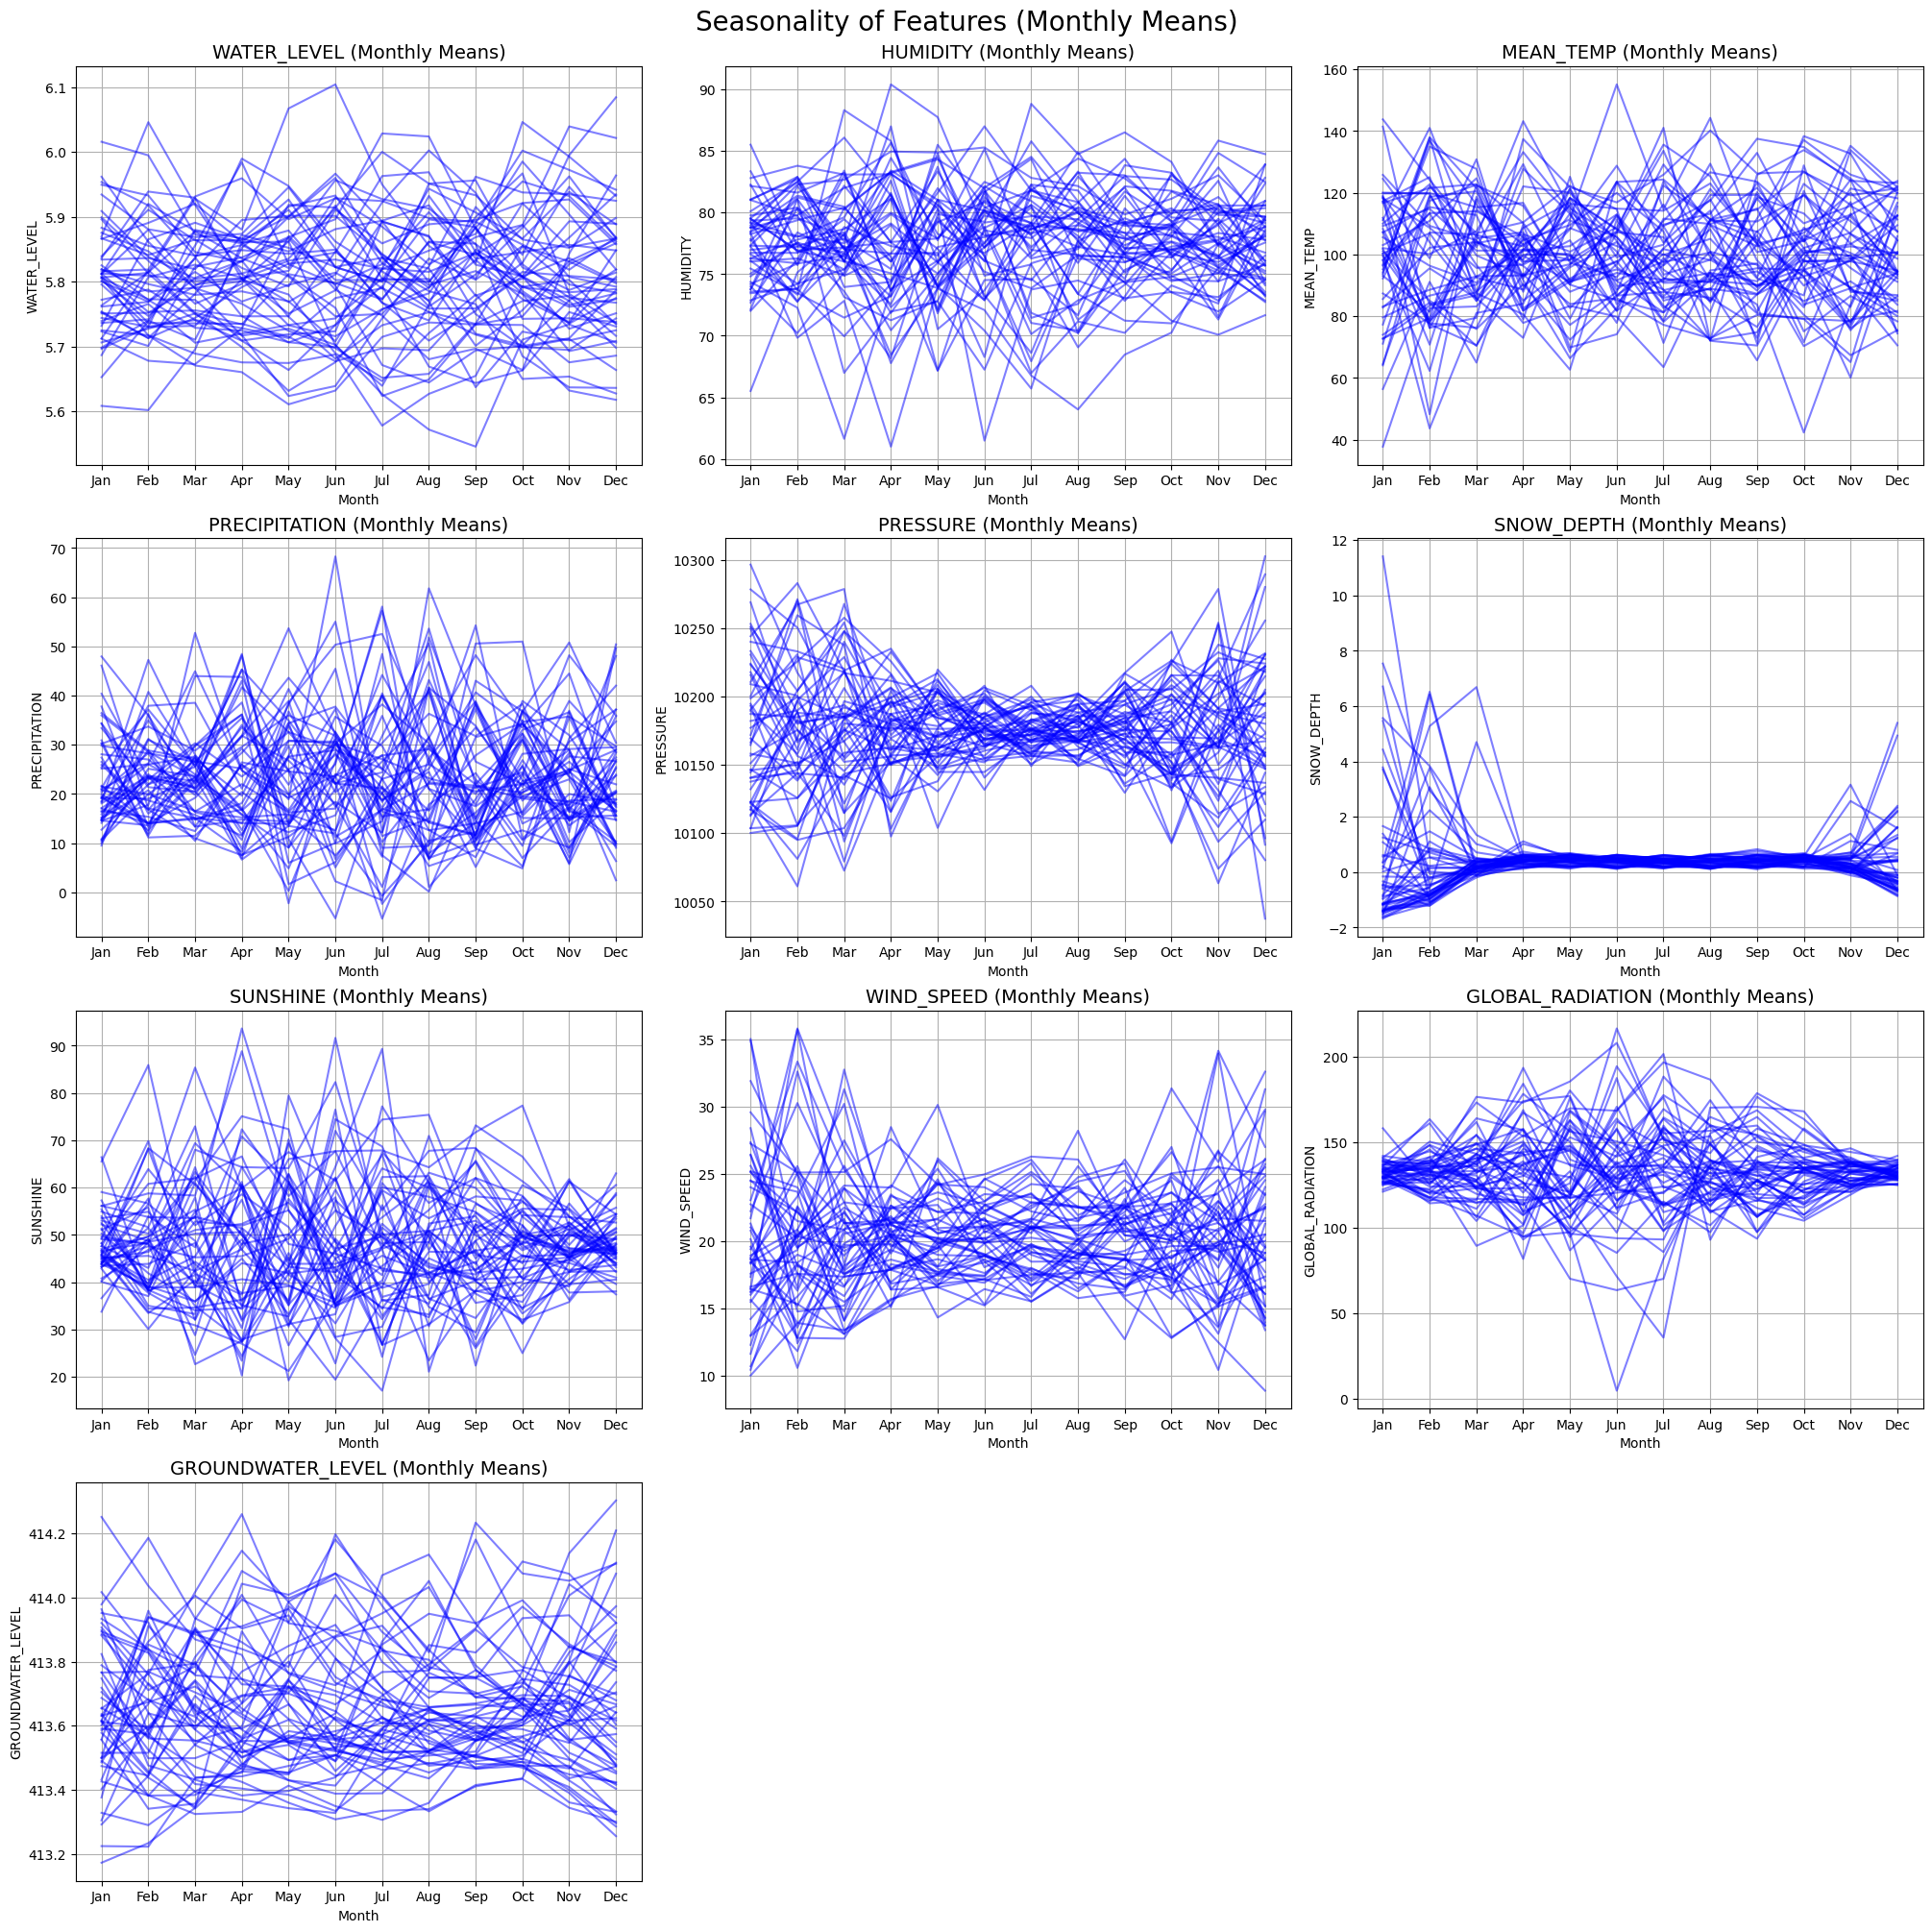

In [ ]:


# plot to assure
df['year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# Calculate monthly means for all features
monthly_means = df.groupby(['year', 'Month']).mean().reset_index()

features = ['WATER_LEVEL', 'HUMIDITY', 'MEAN_TEMP', 'PRECIPITATION', 'PRESSURE',
            'SNOW_DEPTH', 'SUNSHINE', 'WIND_SPEED', 'GLOBAL_RADIATION',
            'GROUNDWATER_LEVEL']

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create subplots
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), constrained_layout=True)
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    for year in monthly_means['year'].unique():
        yearly_data = monthly_means[monthly_means['year'] == year]
        ax.plot(yearly_data['Month'], yearly_data[feature], alpha=0.5, label=f"{year}", color="blue")

    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels)
    ax.set_title(f"{feature} (Monthly Means)", fontsize=14)
    ax.set_xlabel("Month")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend([], frameon=False)

# Hide unused subplots
for i in range(len(features), len(axes)):
    axes[i].axis('off')

plt.suptitle("Seasonality of Features (Monthly Means)", fontsize=20)
plt.show()


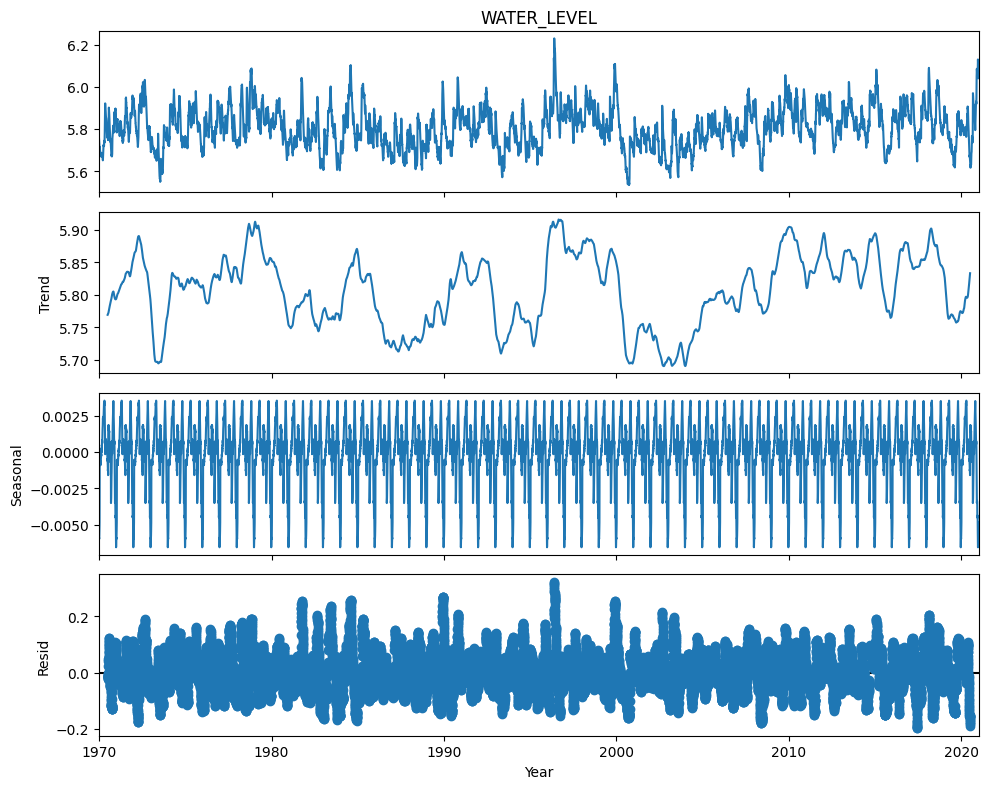

In [ ]:
#decompose again to see whole time series
#df['DATE'] = pd.to_datetime(df['DATE'])

#df.set_index('DATE', inplace=True)

# Decompose the time series
result = seasonal_decompose(df['WATER_LEVEL'], model='additive', period=365)

# Plot
fig = result.plot()
fig.set_size_inches(10, 8)

for ax in fig.axes[:-1]:
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel("")

fig.axes[-1].xaxis.set_major_locator(mdates.YearLocator(10))
fig.axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.axes[-1].set_xlabel("Year")

plt.tight_layout()
plt.show()

In [ ]:
#was no long time trend (in notebook 3) but see trend on decomposition (non-consistent) -> chech statistically bc make stationarity check according to: https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.stattools import adfuller

#check adf again just to be sure
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(train["WATER_LEVEL"])
adf_test(test["WATER_LEVEL"])
# because the ADF test statistically confirms whether the series is stationary in the context of mean and variance, which is the key requirement for ARMA models.
##The null hypothesis of the ADF test is that the time series has a unit root, meaning it is non-stationary
# (i.e., it exhibits trends or changing statistical properties over time).
#Rejection of the Null Hypothesis:
#The test statistic (-17.36) is much smaller than the critical values at all significance levels (1%, 5%, and 10%).
#The p-value (0.000) is far below the standard threshold (typically 0.05).
#Conclusion: The null hypothesis is rejected. This indicates that the series is likely stationary.
#The ADF test suggests that the water level series, as it is, does not have a unit root and is stationary.
#Since the water levels already appear stationary, there is no need to detrend them further.
#Detrending water levels in this case would unnecessarily remove essential variability that the model should capture.


#check KPSS:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(train["WATER_LEVEL"])
kpss_test(test["WATER_LEVEL"])
#The null hypothesis for the KPSS test is that the data are stationary. For this test, we do NOT want to reject the null hypothesis.
#p-value of 0.1, means the null hypthesis wasn't rejected and the series is stationary for train and test data
#The KPSS test (Kwiatkowski-Phillips-Schmidt-Shin) is the opposite of the Augmented Dickey-Fuller (ADF) test in terms of its null and alternative hypotheses.
#-> Fail to reject the null hypothesis in both statistical testings -> This suggests the series is likely stationary around a deterministic trend.
#so we're in case 2 of https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html, which means that:
#Case 2: Both tests conclude that the series is stationary - The series is stationary , so the visual trend from decomposition is likely to be deterministic which does not
#violate stationarity in ARMA and we're not going to detrend

Results of Dickey-Fuller Test:
Test Statistic                -1.115322e+01
p-value                        2.908557e-20
#Lags Used                     7.000000e+00
Number of Observations Used    1.642800e+04
Critical Value (1%)           -3.430748e+00
Critical Value (5%)           -2.861716e+00
Critical Value (10%)          -2.566864e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -5.531144
p-value                           0.000002
#Lags Used                       26.000000
Number of Observations Used    2164.000000
Critical Value (1%)              -3.433375
Critical Value (5%)              -2.862877
Critical Value (10%)             -2.567482
dtype: float64
Results of KPSS Test:
Test Statistic            0.358427
p-value                   0.095075
Lags Used                75.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS T

C:\Users\Sina\AppData\Local\Temp\ipykernel_11596\2922186389.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
#However, still have to check if need to detrend features

#start with climate change because most likely to have a trend

df.reset_index(inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'])
# Extract the year from the date
df['year'] = df['DATE'].dt.year

# Aggregate climate change by year because only have yearly values
yearly_climate_change = df.groupby('year')['CLIMATE_CHANGE'].mean().reset_index()

#check for climate change trend with adf:
adf_test(yearly_climate_change['CLIMATE_CHANGE'])
#see clear trend (p-value almost 1)-> clear statistical trend

Results of Dickey-Fuller Test:
Test Statistic                  0.093030
p-value                         0.965582
#Lags Used                     10.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


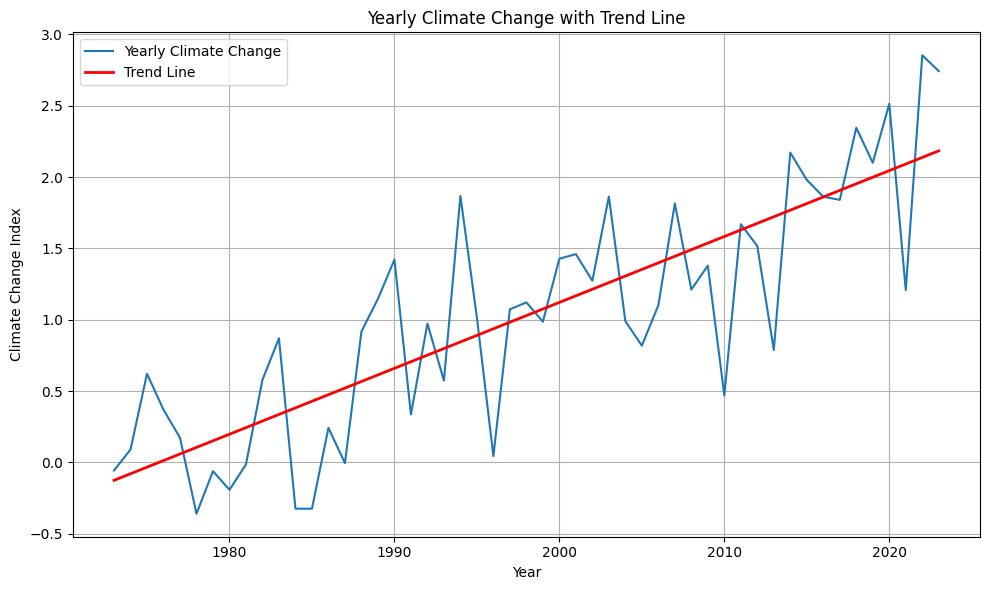

In [ ]:
#plot trend:
import numpy as np
from sklearn.linear_model import LinearRegression

# Extract yearly climate change data
x = yearly_climate_change['year'].values.reshape(-1, 1)
y = yearly_climate_change['CLIMATE_CHANGE'].values

# Fit a linear regression model for the trend line
model = LinearRegression()
model.fit(x, y)
trend_line = model.predict(x)

plt.figure(figsize=(10, 6))
plt.plot(yearly_climate_change['year'], yearly_climate_change['CLIMATE_CHANGE'], label='Yearly Climate Change')
plt.plot(yearly_climate_change['year'], trend_line, color='red', label='Trend Line', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Climate Change Index')
plt.title('Yearly Climate Change with Trend Line')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
#check for a trend in the other columns:
columns_to_test = [
    "HUMIDITY", "MEAN_TEMP", "PRECIPITATION", "PRESSURE", "SNOW_DEPTH",
    "SUNSHINE", "WIND_SPEED", "GLOBAL_RADIATION", "GROUNDWATER_LEVEL", "MOON_ILLUMINATION"
]
for column in columns_to_test:
    adf_test(df[column])
#see that none of the features have a trend / all of them are stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.702057e+01
p-value                        8.462780e-30
#Lags Used                     3.600000e+01
Number of Observations Used    1.859000e+04
Critical Value (1%)           -3.430702e+00
Critical Value (5%)           -2.861695e+00
Critical Value (10%)          -2.566853e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -31.621402
p-value                            0.000000
#Lags Used                         8.000000
Number of Observations Used    18618.000000
Critical Value (1%)               -3.430701
Critical Value (5%)               -2.861695
Critical Value (10%)              -2.566853
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -114.273704
p-value                            0.000000
#Lags Used                         0.000000
Number of Observations Used    18626.000000
Critical Value (1%)               -3.430701
Critical Value (5%)               -2.8616

In [ ]:
#check whether trend of climate change correlates with deterministic trend from decomposition of the water levels
yearly_data = df.groupby('year')['WATER_LEVEL'].mean().reset_index()

merged_data = pd.merge(yearly_data, yearly_climate_change, on='year', how='inner')


# Since seasonal_decompose requires time series with a proper index and a period, set the year as the index
merged_data.set_index('year', inplace=True)

# Decompose water level and climate change index into trends (adjust period to 1 for yearly data)
water_level_decomp = seasonal_decompose(merged_data['WATER_LEVEL'], model='additive', period=1)
climate_change_decomp = seasonal_decompose(merged_data['CLIMATE_CHANGE'], model='additive', period=1)

#trends
water_level_trend = water_level_decomp.trend
climate_change_trend = climate_change_decomp.trend

#indices
common_index = water_level_trend.index.intersection(climate_change_trend.index)
water_level_trend = water_level_trend.loc[common_index]
climate_change_trend = climate_change_trend.loc[common_index]

#correlation
trend_correlation = water_level_trend.corr(climate_change_trend)
print(f"Trend Correlation: {trend_correlation:.2f}")

#The trend in climate change dominates but is not meaningful: A weak correlation suggests that
# the trend in climate change does not explain the variability in water levels.
#The correlation result suggests that there is no linear relationship between climate change and water levels.
#However, this does not rule out non-linear relationships or lagged effects between climate change and water levels-> leave it in as a feature
#To focus on short-term deviations: Detrending removes the long-term trend and focuses on variations, which might better explain water levels.
#A trending feature may dominate or create spurious relationships with the target, even if there's no meaningful correlation.
#This means: detrending the climate change feature but keeping the water levels as they are (stationary) is the best approach.

Trend Correlation: 0.11


In [ ]:
print(df['CLIMATE_CHANGE'])

0       -0.061
1       -0.056
2       -0.056
3       -0.056
4       -0.056
         ...  
18622    2.742
18623    2.742
18624    2.742
18625    2.742
18626    2.742
Name: CLIMATE_CHANGE, Length: 18627, dtype: float64


In [ ]:
#detrend climate change:
# need to use linear regression for it because only have 1 observation per year and henve seasonal_decompose assumes there is no seasonality
#(as only one observation per period is analyzed)-> trend effectively becomes identical to the original data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
import numpy as np

def detrend_climate_change(dataset):
    dataset['DATE'] = pd.to_datetime(dataset['DATE'])
    # yearly because same over year
    dataset['year'] = dataset['DATE'].dt.year
    yearly_climate_change = dataset.groupby('year')['CLIMATE_CHANGE'].mean()

    # lin regression to detrend because with differencing a whole year would be missing in our datasets, furthermore by removing the trend using linear regression,
    # the residual data (detrended) is more stationary and aligns well with the assumptions of linear regression.
    x = np.array(yearly_climate_change.index).reshape(-1, 1)
    y = yearly_climate_change.values

    model = LinearRegression()
    model.fit(x, y)
    trend = model.predict(x)
    detrended_climate_change = yearly_climate_change - trend

    detrended_yearly_map = detrended_climate_change.to_dict()
    dataset['CLIMATE_CHANGE'] = dataset['year'].map(detrended_yearly_map)

    return dataset

# Apply detrending to df, train, and test
datasets = {'df': df, 'train': train, 'test': test}
for name, dataset in datasets.items():
    datasets[name] = detrend_climate_change(dataset)




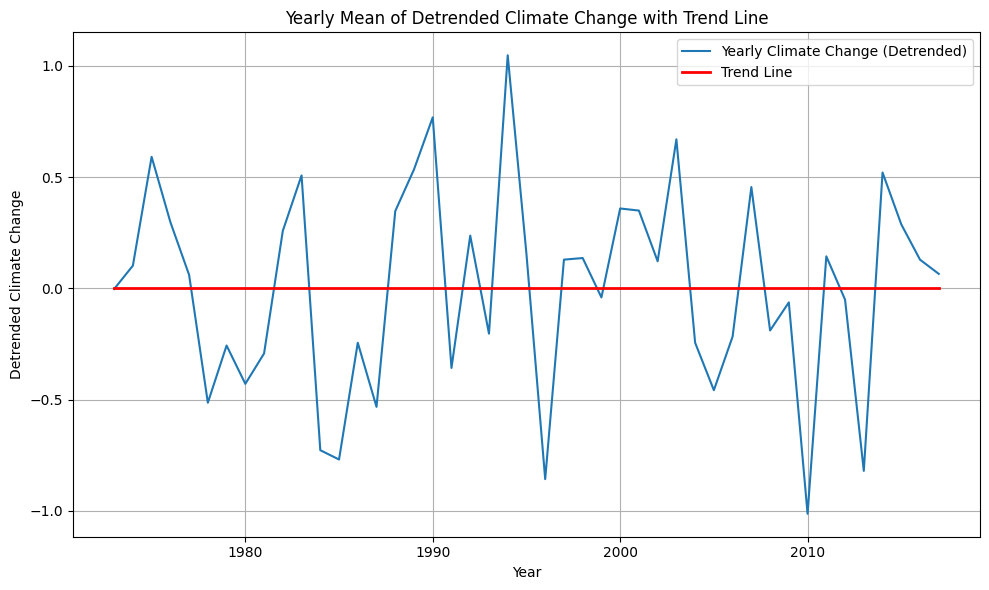

In [ ]:
#plot to see if no trend:
yearly_mean_detrended = train.groupby('year')['CLIMATE_CHANGE'].mean().reset_index()

# Fit a linear regression model to the yearly mean
x = yearly_mean_detrended['year'].values.reshape(-1, 1)
y = yearly_mean_detrended['CLIMATE_CHANGE'].values
model = LinearRegression()
model.fit(x, y)
trend_line = model.predict(x)

# Plot the yearly mean and the red trend line
plt.figure(figsize=(10, 6))
plt.plot(yearly_mean_detrended['year'], yearly_mean_detrended['CLIMATE_CHANGE'],
         label='Yearly Climate Change (Detrended)')
plt.plot(yearly_mean_detrended['year'], trend_line, color='red', label='Trend Line', linewidth=2)
plt.title('Yearly Mean of Detrended Climate Change with Trend Line')
plt.xlabel('Year')
plt.ylabel('Detrended Climate Change')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
train.drop("year", axis=1, inplace=True)
test.drop("year", axis=1, inplace=True)
print(train.head())
print(test.head())
print(df.head())

        DATE  WATER_LEVEL   HUMIDITY  MEAN_TEMP  PRECIPITATION      PRESSURE  \
0 1973-01-01     5.751083  67.901296  63.313885       1.180605  10234.074400   
1 1973-01-02     5.747830  75.727348  56.815821      12.945014  10206.457564   
2 1973-01-03     5.744990  77.487765  71.536043       6.306917  10247.625968   
3 1973-01-04     5.742506  71.943417  87.365138       9.374768  10262.648252   
4 1973-01-05     5.737028  75.052494  86.495127      -0.387271  10288.310334   

   SNOW_DEPTH    SUNSHINE  WIND_SPEED  GLOBAL_RADIATION  ...  \
0   -0.394252  107.114456    4.033825        174.365515  ...   
1   -0.242098   54.869026    6.338837        146.059262  ...   
2   -0.166031   51.621253    3.448197        142.157053  ...   
3   -0.470399   47.762258    9.819856        136.656399  ...   
4   -0.524767   40.438623   17.081986        134.474983  ...   

   MOON_ILLUMINATION  CLIMATE_CHANGE  WATER_LEVEL_LAG_1  WATER_LEVEL_LAG_2  \
0           18.48788       -0.002712           5.761000 

In [ ]:
train.to_csv("C:/Users/Sina/Documents/HSG/Econ Bachelor/DSF/train_detrended.csv", index=False)
test.to_csv("C:/Users/Sina/Documents/HSG/Econ Bachelor/DSF/test_detrended.csv", index=False)